In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as color
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import csv
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import requests
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import folium
import math
from bs4 import BeautifulSoup

# **Data Exploration** #

In [2]:
df = pd.read_csv("listings.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,78,2020-09-20,0.58,1,180
1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,33,2018-07-15,0.42,2,364
2,23001,Apartmento Arganzuela- Madrid Rio,82175,Jesus,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,0,NaN,NaN,7,1
3,24805,Gran Via Studio Madrid,346366726,A,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,10,2020-03-01,0.13,1,72
4,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,149,2020-03-12,1.12,1,365


In [3]:
frequency = pd.DataFrame(df["neighbourhood"].value_counts())
frequency.reset_index(inplace=True)
frequency.rename(columns={"index":"neighbourhood", "neighbourhood":"airbnb_count"}, inplace=True)
frequency.head()

,neighbourhood,airbnb_count
0,Embajadores,2318
1,Universidad,1869
2,Palacio,1506
3,Sol,1125
4,Justicia,951


In [4]:
medium_price = df.groupby('neighbourhood', as_index=False)['price'].mean()
medium_price.rename(columns={"price":"medium_price"}, inplace=True)
medium_price.head()

,neighbourhood,medium_price
0,Abrantes,57.382979
1,Acacias,156.176471
2,Adelfas,55.391304
3,Aeropuerto,40.727273
4,Aguilas,66.150943


In [5]:
data = pd.merge(medium_price, frequency, on="neighbourhood")
data.drop(data[data["neighbourhood"]=="Casco Histórico de Barajas"].index, inplace=True)
data.drop(data[data["neighbourhood"]=="Fuentelareina"].index, inplace=True)
data.head()

,neighbourhood,medium_price,airbnb_count
0,Abrantes,57.382979,47
1,Acacias,156.176471,170
2,Adelfas,55.391304,92
3,Aeropuerto,40.727273,11
4,Aguilas,66.150943,53


### **Importing the neighbourhoods coordinates** ###

In [6]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Madrid")
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 40.4167047, Longitude = -3.7035825


In [7]:
LONGITUDE = []
LATITUDE = []
for neigh in data["neighbourhood"]:
        loc = neigh + ", Comunidad de Madrid, España"
        location = locator.geocode(loc)
        LATITUDE.append(location.latitude)
        LONGITUDE.append(location.longitude)
        
data["latitude"] = LATITUDE
data["longitude"] = LONGITUDE
data.head()

,neighbourhood,medium_price,airbnb_count,latitude,longitude
0,Abrantes,57.382979,47,40.380998,-3.727985
1,Acacias,156.176471,170,40.404075,-3.705957
2,Adelfas,55.391304,92,40.401903,-3.670958
3,Aeropuerto,40.727273,11,40.494838,-3.574081
4,Aguilas,66.150943,53,40.362609,-4.429212


# **Data Visualization** #

<BarContainer object of 20 artists>

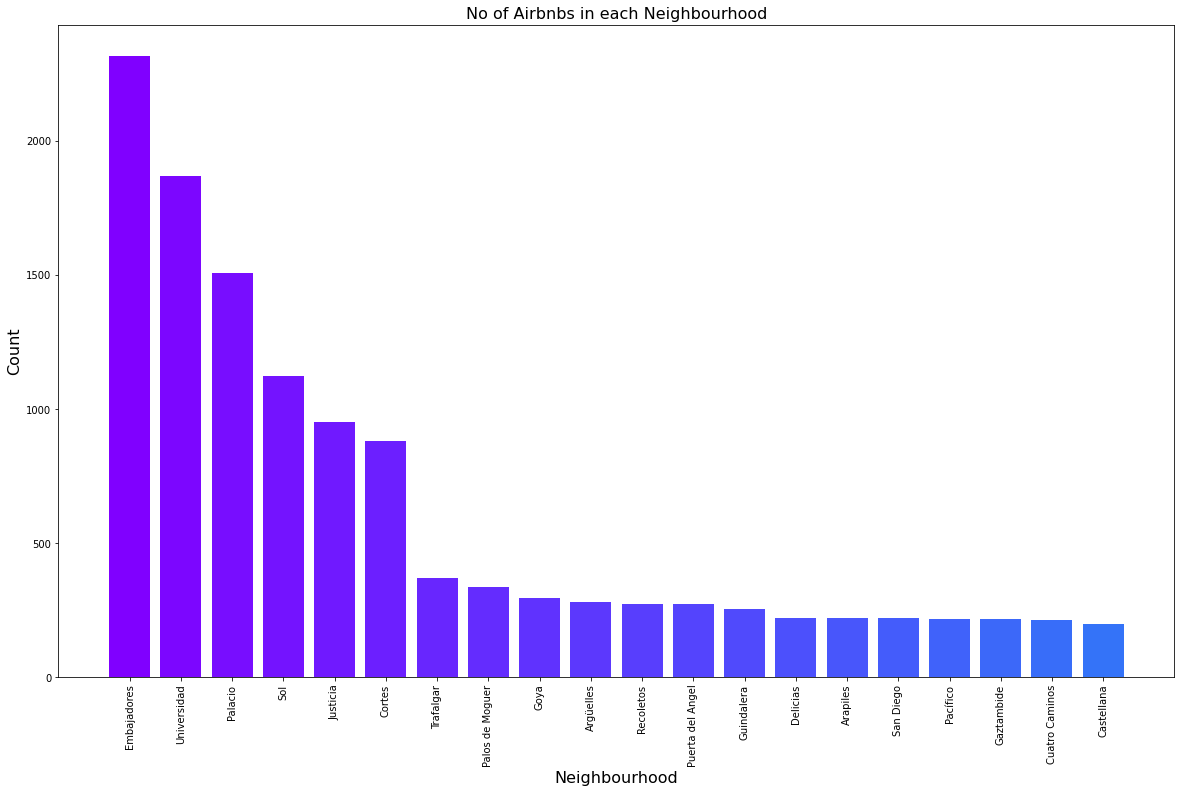

In [8]:
frequency.sort_values('airbnb_count', ascending=False, inplace=True)
count = frequency['airbnb_count']
neighbourhood = frequency['neighbourhood']

colors_ = cm.rainbow(np.linspace(0, 1, len(count.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Neighbourhood", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("No of Airbnbs in each Neighbourhood", fontsize = 16)
plt.bar(neighbourhood[:20], count[:20].values, color = colors_)

In [9]:
address = 'Madrid'

geolocator = Nominatim(user_agent="MAD_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


In [10]:
map_state = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, district in zip(data['latitude'], data['longitude'], data['neighbourhood']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_state)  
    
map_state

# **Foursquare API** #

### **Define Foursquare Credentials and Version**


In [11]:
CLIENT_ID = 'DOCDMDMJQWA2I2VUFKUVNQWBZ3G3WIRKRP5UWLSQFZMR055W'
#'SOIPHAZD2WR5JNYSLN5AVK2MBXOL1BIHQVKF3BF52OFBZTNJ' 
CLIENT_SECRET = 'MAOEKE35GBPXYSHZL1OUQ5BLJGA3VRRALNSMBZHDSUJSYV3L'
#'WFVEXNQQAFQHL31UJZ1GRD5A2A1DC2UFYOVBHNEZHRKDDW4J' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DOCDMDMJQWA2I2VUFKUVNQWBZ3G3WIRKRP5UWLSQFZMR055W
CLIENT_SECRET:MAOEKE35GBPXYSHZL1OUQ5BLJGA3VRRALNSMBZHDSUJSYV3L


In [13]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

category_results = requests.get(url).json()
category_results

{'meta': {'code': 200, 'requestId': '60f84e1e1e82632c95d4a0bf'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

In [14]:
categories = len(category_results['response']['categories'])

for i in range(categories):
    venues = category_results['response']['categories'][i]['name']
    print(venues)
    for j in range(len(category_results['response']['categories'][i]['categories'])):
        sub_venues = category_results['response']['categories'][i]['categories'][j]['name']
        print('\t\t' + sub_venues)

Arts & Entertainment
		Amphitheater
		Aquarium
		Arcade
		Art Gallery
		Bowling Alley
		Casino
		Circus
		Comedy Club
		Concert Hall
		Country Dance Club
		Disc Golf
		Escape Room
		Exhibit
		General Entertainment
		Go Kart Track
		Historic Site
		Karaoke Box
		Laser Tag
		Memorial Site
		Mini Golf
		Movie Theater
		Museum
		Music Venue
		Pachinko Parlor
		Performing Arts Venue
		Pool Hall
		Public Art
		Racecourse
		Racetrack
		Roller Rink
		Salsa Club
		Samba School
		Stadium
		Theme Park
		Tour Provider
		VR Cafe
		Water Park
		Zoo
College & University
		College Academic Building
		College Administrative Building
		College Auditorium
		College Bookstore
		College Cafeteria
		College Classroom
		College Gym
		College Lab
		College Library
		College Quad
		College Rec Center
		College Residence Hall
		College Stadium
		College Theater
		Community College
		Fraternity House
		General College & University
		Law School
		Medical School
		Sorority House
		Student Center
		Trade School
		U

In [15]:
all_categories = {}

for i in range(categories):
    venues = category_results['response']['categories'][i]['name']
    all_categories[venues] = i

print(all_categories)

{'Arts & Entertainment': 0, 'College & University': 1, 'Event': 2, 'Food': 3, 'Nightlife Spot': 4, 'Outdoors & Recreation': 5, 'Professional & Other Places': 6, 'Residence': 7, 'Shop & Service': 8, 'Travel & Transport': 9}


### **Choosing the venues categories I want to search for**

In [16]:
selected_category = []
req_categories = ['Residence', 'College & University', 'Food', 'Shop & Service', 'Travel & Transport', 'Nightlife Spot', 'Arts & Entertainment', 'Professional & Other Places', 'Event', 'Outdoors & Recreation']

for i in req_categories:
    key = all_categories.get(i)
    venues = category_results['response']['categories'][key]['name']
    selected_category.append(venues)
    for j in range(len(category_results['response']['categories'][key]['categories'])):
        sub_venues = category_results['response']['categories'][key]['categories'][j]['name']
        selected_category.append(sub_venues)
selected_category

['Residence',
 'Assisted Living',
 'Home (private)',
 'Housing Development',
 'Residential Building (Apartment / Condo)',
 'Trailer Park',
 'College & University',
 'College Academic Building',
 'College Administrative Building',
 'College Auditorium',
 'College Bookstore',
 'College Cafeteria',
 'College Classroom',
 'College Gym',
 'College Lab',
 'College Library',
 'College Quad',
 'College Rec Center',
 'College Residence Hall',
 'College Stadium',
 'College Theater',
 'Community College',
 'Fraternity House',
 'General College & University',
 'Law School',
 'Medical School',
 'Sorority House',
 'Student Center',
 'Trade School',
 'University',
 'Food',
 'Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Armenian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bangladeshi Restaurant',
 'Belgian Restaurant',
 'Bistro',
 'Breakfast Spot',
 'Bubble Tea Shop',
 'Buffet',
 'Burger Joint',
 

### **Function to extract the neighbourhood nearby venues**

In [17]:
LIMIT = 50

def getNearbyVenues_(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    nearby_venues = nearby_venues[nearby_venues['Venue Category'].isin(selected_category)]
    
    return(nearby_venues)

In [18]:
state_venues = getNearbyVenues_(names=data["neighbourhood"],
                                   latitudes=data['latitude'],
                                   longitudes=data['longitude']
                                  )

Abrantes
Acacias
Adelfas
Aeropuerto
Aguilas
Alameda de Osuna
Almagro
Almenara
Almendrales
Aluche
Ambroz
Amposta
Apostol Santiago
Arapiles
Aravaca
Arcos
Argüelles
Atalaya
Atocha
Bellas Vistas
Berruguete
Buenavista
Butarque
Campamento
Canillas
Canillejas
Casa de Campo
Casco Histórico de Vallecas
Casco Histórico de Vicálvaro
Castellana
Castilla
Castillejos
Chopera
Ciudad Jardín
Ciudad Universitaria
Colina
Comillas
Concepción
Corralejos
Cortes
Costillares
Cuatro Caminos
Cuatro Vientos
Cármenes
Delicias
El Goloso
El Pardo
El Plantío
El Viso
Embajadores
Entrevías
Estrella
Fontarrón
Fuente del Berro
Gaztambide
Goya
Guindalera
Hellín
Hispanoamérica
Horcajo
Ibiza
Imperial
Jerónimos
Justicia
La Paz
Legazpi
Lista
Los Angeles
Los Rosales
Lucero
Marroquina
Media Legua
Mirasierra
Moscardó
Niño Jesús
Nueva España
Numancia
Opañel
Orcasitas
Orcasur
Pacífico
Palacio
Palomas
Palomeras Bajas
Palomeras Sureste
Palos de Moguer
Pavones
Peñagrande
Pilar
Pinar del Rey
Piovera
Portazgo
Pradolongo
Prosperidad
Pu

In [20]:
print(state_venues.shape)
state_venues.head()

(4133, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abrantes,40.380998,-3.727985,Parque Emperatriz María de Austria,40.377936,-3.721962,Park
2,Abrantes,40.380998,-3.727985,La Peña Soriana,40.382060,-3.711332,Spanish Restaurant
4,Abrantes,40.380998,-3.727985,Pradera de San Isidro,40.399038,-3.724606,Park
5,Abrantes,40.380998,-3.727985,El Rincón del Greco,40.379848,-3.748790,Gastropub
6,Abrantes,40.380998,-3.727985,Madrid Río (Sector Central),40.396744,-3.712842,Park


In [21]:
print('There are {} uniques categories.'.format(len(state_venues['Venue Category'].unique())))
print(state_venues['Venue Category'].unique())

There are 144 uniques categories.
['Park' 'Spanish Restaurant' 'Gastropub' 'Bridge' 'Athletics & Sports'
 'Comedy Club' 'BBQ Joint' 'Bakery' 'Sporting Goods Shop'
 'Italian Restaurant' 'Bookstore' 'Shopping Mall' 'Plaza' 'Restaurant'
 'Candy Store' 'Salad Place' 'Cafeteria' 'Seafood Restaurant'
 'Clothing Store' 'Fast Food Restaurant' 'Concert Hall'
 'Furniture / Home Store' 'Art Gallery' 'Event Space' 'Market'
 'Coffee Shop' 'Pizza Place' 'Circus' 'Food & Drink Shop' 'Bar' 'Bistro'
 'Vegetarian / Vegan Restaurant' 'Mediterranean Restaurant' 'Café'
 'Brewery' 'Movie Theater' 'Burger Joint' 'Museum' 'Hotel' 'Garden'
 'Polish Restaurant' 'Eastern European Restaurant' 'Mexican Restaurant'
 'Scenic Lookout' 'Flea Market' 'Airport' 'Deli / Bodega' 'Train Station'
 'Breakfast Spot' 'Duty-free Shop' 'Snack Place' 'Sandwich Place' 'Diner'
 'Castle' 'Construction & Landscaping' 'Juice Bar' 'Rental Car Location'
 'Jewelry Store' 'Steakhouse' 'Library' 'Motorcycle Shop' 'Art Studio'
 'American Re

### **Venue analysis for each neighbouhood**

In [22]:
state_venues_onehot = pd.get_dummies(state_venues[['Venue Category']], prefix="", prefix_sep="")

state_venues_onehot['District'] = state_venues['District'] 

fixed_columns = [state_venues_onehot.columns[-1]] + list(state_venues_onehot.columns[:-1])
state_venues_onehot = state_venues_onehot[fixed_columns]

state_venues_onehot.head()

,District,Airport,American Restaurant,Aquarium,Art Gallery,Art Studio,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Tea Room,Theme Park,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Zoo
0,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
state_venues_grouped = state_venues_onehot.groupby('District').mean().reset_index()
state_venues_grouped.head()

,District,Airport,American Restaurant,Aquarium,Art Gallery,Art Studio,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Tea Room,Theme Park,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Zoo
0,Abrantes,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029412,0.0,0.029412,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Acacias,0.000000,0.0,0.0,0.096774,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.032258,0.0
2,Adelfas,0.000000,0.0,0.0,0.028571,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.028571,0.0
3,Aeropuerto,0.032258,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.000000,0.0
4,Aguilas,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


### **Most common venues for each neighbourhood**

In [24]:
num_top_venues = 10

for hood in state_venues_grouped['District']:
    print("----"+hood+"----")
    temp = state_venues_grouped[state_venues_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abrantes----
                    venue  freq
0                    Park  0.12
1      Spanish Restaurant  0.12
2              Restaurant  0.09
3      Italian Restaurant  0.06
4          Clothing Store  0.06
5           Shopping Mall  0.06
6               Gastropub  0.06
7                   Plaza  0.03
8     Sporting Goods Shop  0.03
9  Furniture / Home Store  0.03


----Acacias----
                venue  freq
0  Spanish Restaurant  0.13
1         Coffee Shop  0.10
2         Art Gallery  0.10
3         Pizza Place  0.10
4                Park  0.06
5   Food & Drink Shop  0.03
6  Seafood Restaurant  0.03
7       Movie Theater  0.03
8                Café  0.03
9               Plaza  0.03


----Adelfas----
                 venue  freq
0   Spanish Restaurant  0.14
1                 Park  0.09
2               Garden  0.06
3               Museum  0.06
4                Hotel  0.06
5   Mexican Restaurant  0.06
6    Food & Drink Shop  0.03
7          Flea Market  0.03
8               Market  0.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
indicators = ['st', 'nd', 'rd']

columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Category'.format(ind+1))

district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = state_venues_grouped['District']

for ind in np.arange(state_venues_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(state_venues_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,Abrantes,Park,Spanish Restaurant,Restaurant,Italian Restaurant,Clothing Store,Shopping Mall,Gastropub,Plaza,Sporting Goods Shop,Furniture / Home Store
1,Acacias,Spanish Restaurant,Coffee Shop,Art Gallery,Pizza Place,Park,Food & Drink Shop,Seafood Restaurant,Movie Theater,Café,Plaza
2,Adelfas,Spanish Restaurant,Park,Garden,Museum,Hotel,Mexican Restaurant,Food & Drink Shop,Flea Market,Market,Sporting Goods Shop
3,Aeropuerto,Spanish Restaurant,Coffee Shop,Hotel,Fast Food Restaurant,Breakfast Spot,Snack Place,Deli / Bodega,Train Station,Sporting Goods Shop,Sandwich Place
4,Aguilas,Fast Food Restaurant,Castle,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Office,Other Nightlife,Airport


# **K-Means Clustering Analysis**

### **Finding the optimal k value**

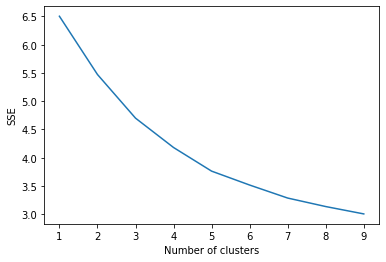

In [27]:
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(state_venues_grouped.drop('District',axis=1))
    state_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### **Dividing the neighbourhoods in different clusters**

In [28]:
kclusters = 4

state_venues_grouped_clustering = state_venues_grouped.drop('District', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(state_venues_grouped_clustering)

kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 2, 2, 2, 0, 3])

In [29]:
state_venues_merged = state_venues[['District']]
new_state_venues = state_venues[['District', 'Venue Latitude', 'Venue Longitude']]

state_venues_merged = state_venues_merged.join(new_state_venues.set_index('District'), on='District')

state_venues_merged = state_venues_merged.join(district_venues_sorted.set_index('District'), on='District')

state_venues_merged.drop_duplicates(subset='District', keep='first', inplace=True)
state_venues_merged["Cluster Labels"] = kmeans.labels_
state_venues_merged.reset_index(inplace=True)
state_venues_merged.tail()

,index,District,Venue Latitude,Venue Longitude,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category,Cluster Labels
121,5822,Valverde,40.497543,-3.687040,Spanish Restaurant,Restaurant,Burger Joint,Coffee Shop,Hotel,Gastropub,Snack Place,Steakhouse,Kebab Restaurant,Massage Studio,2
122,5873,Ventas,40.431458,-3.663064,Spanish Restaurant,Bar,Restaurant,Indian Restaurant,Burger Joint,Mediterranean Restaurant,Pool Hall,Italian Restaurant,Park,Seafood Restaurant,2
123,5922,Vinateros,40.410584,-3.628595,Park,Spanish Restaurant,Bar,Plaza,Pool,Athletics & Sports,Restaurant,Brewery,Pizza Place,Eastern European Restaurant,1
124,5973,Vista Alegre,40.379848,-3.748790,Park,Italian Restaurant,Restaurant,Bar,Comedy Club,Spanish Restaurant,Bakery,Plaza,Burger Joint,Gastropub,3
125,6022,Zofío,40.382060,-3.711332,Park,Spanish Restaurant,Bar,Sporting Goods Shop,Seafood Restaurant,Burger Joint,Cafeteria,Gastropub,Garden,Music Venue,0


### **Clusters visualization**

In [30]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [color.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(state_venues_merged['Venue Latitude'], state_venues_merged['Venue Longitude'], state_venues_merged['District'], state_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

### **Cluster Analysis**

In [31]:
cluster0 = state_venues_merged.loc[state_venues_merged['Cluster Labels'] == 0, state_venues_merged.columns[[0] + list(range(4, state_venues_merged.shape[1]))]]
cluster0

,index,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category,Cluster Labels
4,201,Fast Food Restaurant,Castle,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Office,Other Nightlife,Airport,0
8,354,Park,Spanish Restaurant,Flea Market,Gastropub,Cafeteria,Burger Joint,Bubble Tea Shop,Bridge,Scenic Lookout,Garden,0
13,605,Spanish Restaurant,Restaurant,Café,Coffee Shop,Burger Joint,Italian Restaurant,Plaza,Hotel,Pizza Place,Park,0
14,654,Restaurant,Spanish Restaurant,Café,Deli / Bodega,Park,Burger Joint,Hotel,Seafood Restaurant,Gastropub,Italian Restaurant,0
15,705,Park,Restaurant,Café,Sandwich Place,Spanish Restaurant,Hotel,Coffee Shop,Breakfast Spot,Hobby Shop,Mediterranean Restaurant,0
16,754,Café,Hotel,Spanish Restaurant,Plaza,Park,Restaurant,Burger Joint,Garden,Movie Theater,Bookstore,0
18,854,Garden,Hotel,Plaza,Spanish Restaurant,Restaurant,Café,Italian Restaurant,Art Gallery,Pizza Place,Brewery,0
21,1004,Hotel,Café,Pizza Place,Clothing Store,Park,Restaurant,Department Store,Shopping Mall,Coffee Shop,Sandwich Place,0
32,1526,Park,Art Gallery,Breakfast Spot,Pizza Place,Coffee Shop,Garden,Plaza,Hotel,Event Space,Restaurant,0
36,1727,Hotel,Coffee Shop,Spanish Restaurant,Restaurant,Plaza,Burger Joint,Bookstore,Café,Garden,Movie Theater,0


In [32]:
cluster0_1sort = cluster0["1st Most Common Venue Category"].value_counts().rename_axis('1st_category').reset_index(name='1counts')
cluster0_2sort = cluster0["2nd Most Common Venue Category"].value_counts().rename_axis('2nd_category').reset_index(name='2counts')
cluster0_3sort = cluster0["3rd Most Common Venue Category"].value_counts().rename_axis('3rd_category').reset_index(name='3counts')
cluster0_4sort = cluster0["4th Most Common Venue Category"].value_counts().rename_axis('4th_category').reset_index(name='4counts')
cluster0_5sort = cluster0["5th Most Common Venue Category"].value_counts().rename_axis('5th_category').reset_index(name='5counts')

first0 = cluster0_1sort["1st_category"][cluster0_1sort["1counts"] == cluster0_1sort["1counts"].max()]
second0 = cluster0_2sort["2nd_category"][cluster0_2sort["2counts"] == cluster0_2sort["2counts"].max()]
third0 = cluster0_3sort["3rd_category"][cluster0_3sort["3counts"] == cluster0_3sort["3counts"].max()]
four0 = cluster0_4sort["4th_category"][cluster0_4sort["4counts"] == cluster0_4sort["4counts"].max()]
fifth0 = cluster0_5sort["5th_category"][cluster0_5sort["5counts"] == cluster0_5sort["5counts"].max()]

first0 = ", ".join(first0)
second0 = ", ".join(second0)
third0 = ", ".join(third0)
four0 = ", ".join(four0)
fifth0 = ", ".join(fifth0)

cluster0_ = pd.DataFrame()
cluster0_.loc['cluster_0','1st_category'] = str(first0)
cluster0_.loc['cluster_0', '2nd_category'] = str(second0)
cluster0_.loc['cluster_0', '3rd_category'] = str(third0)
cluster0_.loc['cluster_0', '4th_category'] = str(four0)
cluster0_.loc['cluster_0', '5th_category'] = str(fifth0)
cluster_0 = cluster0_.transpose()
cluster_0

,cluster_0
1st_category,Park
2nd_category,"Restaurant, Spanish Restaurant, Art Gallery"
3rd_category,Spanish Restaurant
4th_category,Plaza
5th_category,Restaurant


In [33]:
cluster1 = state_venues_merged.loc[state_venues_merged['Cluster Labels'] == 1, state_venues_merged.columns[[0] + list(range(4, state_venues_merged.shape[1]))]]
cluster1

,index,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category,Cluster Labels
0,0,Park,Spanish Restaurant,Restaurant,Italian Restaurant,Clothing Store,Shopping Mall,Gastropub,Plaza,Sporting Goods Shop,Furniture / Home Store,1
1,50,Spanish Restaurant,Coffee Shop,Art Gallery,Pizza Place,Park,Food & Drink Shop,Seafood Restaurant,Movie Theater,Café,Plaza,1
2,100,Spanish Restaurant,Park,Garden,Museum,Hotel,Mexican Restaurant,Food & Drink Shop,Flea Market,Market,Sporting Goods Shop,1
10,454,Pizza Place,Park,Fast Food Restaurant,Seafood Restaurant,Café,Spanish Restaurant,Hotel,Breakfast Spot,Plaza,Pool,1
11,504,Restaurant,Park,Bar,Spanish Restaurant,Café,Hotel,Coffee Shop,Sandwich Place,Bakery,Asian Restaurant,1
19,904,Spanish Restaurant,Hotel,Italian Restaurant,Café,Bar,Park,Seafood Restaurant,Pizza Place,Bakery,Kebab Restaurant,1
22,1054,Train Station,Athletics & Sports,Spanish Restaurant,Shopping Mall,Metro Station,Pizza Place,Pet Store,Convenience Store,Electronics Store,Sandwich Place,1
25,1176,Spanish Restaurant,Park,Hotel,Restaurant,Italian Restaurant,Sandwich Place,Bakery,Coffee Shop,Café,Garden,1
26,1226,Park,Spanish Restaurant,Restaurant,Pool,Bar,Zoo,Scenic Lookout,Sandwich Place,Pizza Place,Snack Place,1
27,1277,Spanish Restaurant,Exhibit,Fast Food Restaurant,Restaurant,Furniture / Home Store,Hotel,Café,Clothing Store,Coffee Shop,Deli / Bodega,1


In [34]:
cluster1_1sort = cluster1["1st Most Common Venue Category"].value_counts().rename_axis('1st_category').reset_index(name='1counts')
cluster1_2sort = cluster1["2nd Most Common Venue Category"].value_counts().rename_axis('2nd_category').reset_index(name='2counts')
cluster1_3sort = cluster1["3rd Most Common Venue Category"].value_counts().rename_axis('3rd_category').reset_index(name='3counts')
cluster1_4sort = cluster1["4th Most Common Venue Category"].value_counts().rename_axis('4th_category').reset_index(name='4counts')
cluster1_5sort = cluster1["5th Most Common Venue Category"].value_counts().rename_axis('5th_category').reset_index(name='5counts')

first1 = cluster1_1sort["1st_category"][cluster1_1sort["1counts"] == cluster1_1sort["1counts"].max()]
second1 = cluster1_2sort["2nd_category"][cluster1_2sort["2counts"] == cluster1_2sort["2counts"].max()]
third1 = cluster1_3sort["3rd_category"][cluster1_3sort["3counts"] == cluster1_3sort["3counts"].max()]
four1 = cluster1_4sort["4th_category"][cluster1_4sort["4counts"] == cluster1_4sort["4counts"].max()]
fifth1 = cluster1_5sort["5th_category"][cluster1_5sort["5counts"] == cluster1_5sort["5counts"].max()]

first1 = ", ".join(first1)
second1 = ", ".join(second1)
third1 = ", ".join(third1)
four1 = ", ".join(four1)
fifth1 = ", ".join(fifth1)

cluster1_ = pd.DataFrame()
cluster1_.loc['cluster_1','1st_category'] = str(first1)
cluster1_.loc['cluster_1', '2nd_category'] = str(second1)
cluster1_.loc['cluster_1', '3rd_category'] = str(third1)
cluster1_.loc['cluster_1', '4th_category'] = str(four1)
cluster1_.loc['cluster_1', '5th_category'] = str(fifth1)

cluster_1 = cluster1_.transpose()
cluster_1

,cluster_1
1st_category,Spanish Restaurant
2nd_category,Park
3rd_category,Park
4th_category,Bar
5th_category,Restaurant


In [35]:
cluster2 = state_venues_merged.loc[state_venues_merged['Cluster Labels'] == 2, state_venues_merged.columns[[0] + list(range(4, state_venues_merged.shape[1]))]]
cluster2

,index,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category,Cluster Labels
3,152,Spanish Restaurant,Coffee Shop,Hotel,Fast Food Restaurant,Breakfast Spot,Snack Place,Deli / Bodega,Train Station,Sporting Goods Shop,Sandwich Place,2
5,204,Hotel,Spanish Restaurant,Restaurant,Italian Restaurant,Garden,Juice Bar,Duty-free Shop,Bakery,Bar,Park,2
6,254,Restaurant,Spanish Restaurant,Plaza,Coffee Shop,Clothing Store,Hotel,Steakhouse,Jewelry Store,Mediterranean Restaurant,Museum,2
7,304,Spanish Restaurant,Restaurant,Hotel,Italian Restaurant,Burger Joint,Art Studio,Steakhouse,Comfort Food Restaurant,American Restaurant,Salad Place,2
12,554,Spanish Restaurant,Hotel,Juice Bar,Park,Restaurant,Indian Restaurant,Asian Restaurant,Soup Place,Plaza,Coffee Shop,2
17,804,Spanish Restaurant,Restaurant,Hotel,Seafood Restaurant,Market,Pizza Place,Park,Convenience Store,Comfort Food Restaurant,Burger Joint,2
20,954,Spanish Restaurant,Hotel,Bar,Burger Joint,Restaurant,Café,Motorcycle Shop,Salad Place,Museum,Park,2
24,1126,Spanish Restaurant,Park,Hotel,Italian Restaurant,Juice Bar,Bakery,Gastropub,Mediterranean Restaurant,Middle Eastern Restaurant,Pizza Place,2
29,1381,Restaurant,Spanish Restaurant,Hotel,Italian Restaurant,Mediterranean Restaurant,Plaza,Coffee Shop,Clothing Store,Indian Restaurant,Salad Place,2
30,1426,Restaurant,Spanish Restaurant,Hotel,Italian Restaurant,Steakhouse,Plaza,Park,Comfort Food Restaurant,Salad Place,Motorcycle Shop,2


In [36]:
cluster2_1sort = cluster2["1st Most Common Venue Category"].value_counts().rename_axis('1st_category').reset_index(name='1counts')
cluster2_2sort = cluster2["2nd Most Common Venue Category"].value_counts().rename_axis('2nd_category').reset_index(name='2counts')
cluster2_3sort = cluster2["3rd Most Common Venue Category"].value_counts().rename_axis('3rd_category').reset_index(name='3counts')
cluster2_4sort = cluster2["4th Most Common Venue Category"].value_counts().rename_axis('4th_category').reset_index(name='4counts')
cluster2_5sort = cluster2["5th Most Common Venue Category"].value_counts().rename_axis('5th_category').reset_index(name='5counts')

first2 = cluster2_1sort["1st_category"][cluster2_1sort["1counts"] == cluster2_1sort["1counts"].max()]
second2 = cluster2_2sort["2nd_category"][cluster2_2sort["2counts"] == cluster2_2sort["2counts"].max()]
third2 = cluster2_3sort["3rd_category"][cluster2_3sort["3counts"] == cluster2_3sort["3counts"].max()]
four2 = cluster2_4sort["4th_category"][cluster2_4sort["4counts"] == cluster2_4sort["4counts"].max()]
fifth2 = cluster2_5sort["5th_category"][cluster2_5sort["5counts"] == cluster2_5sort["5counts"].max()]

first2 = ", ".join(first2)
second2 = ", ".join(second2)
third2 = ", ".join(third2)
four2 = ", ".join(four2)
fifth2 = ", ".join(fifth2)

cluster2_ = pd.DataFrame()
cluster2_.loc['cluster_2','1st_category'] = str(first2)
cluster2_.loc['cluster_2', '2nd_category'] = str(second2)
cluster2_.loc['cluster_2', '3rd_category'] = str(third2)
cluster2_.loc['cluster_2', '4th_category'] = str(four2)
cluster2_.loc['cluster_2', '5th_category'] = str(fifth2)

cluster_2 = cluster2_.transpose()
cluster_2

,cluster_2
1st_category,Spanish Restaurant
2nd_category,Restaurant
3rd_category,Hotel
4th_category,Italian Restaurant
5th_category,"Italian Restaurant, Restaurant, Steakhouse, Pl..."


In [37]:
cluster3 = state_venues_merged.loc[state_venues_merged['Cluster Labels'] == 3, state_venues_merged.columns[[0] + list(range(4, state_venues_merged.shape[1]))]]
cluster3

,index,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category,Cluster Labels
9,404,Italian Restaurant,Bar,Spanish Restaurant,Park,Bakery,Athletics & Sports,Pizza Place,Comedy Club,Zoo,Concert Hall,3
23,1076,Italian Restaurant,Bar,Spanish Restaurant,Park,Pizza Place,Athletics & Sports,Comedy Club,Bakery,Breakfast Spot,Gastropub,3
38,1827,Construction & Landscaping,Polish Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Office,Other Nightlife,Palace,Paper / Office Supplies Store,3
42,1978,Bar,Spanish Restaurant,Pizza Place,Italian Restaurant,Park,Athletics & Sports,Restaurant,Sandwich Place,Shopping Mall,Burger Joint,3
43,2029,Park,Italian Restaurant,Restaurant,Comedy Club,Bakery,Zoo,Spanish Restaurant,Plaza,Brewery,Theme Park,3
95,4544,Park,Bar,Bakery,Spanish Restaurant,Athletics & Sports,Concert Hall,Italian Restaurant,Pharmacy,Racetrack,Bridge,3
124,5973,Park,Italian Restaurant,Restaurant,Bar,Comedy Club,Spanish Restaurant,Bakery,Plaza,Burger Joint,Gastropub,3


In [38]:
cluster3_1sort = cluster3["1st Most Common Venue Category"].value_counts().rename_axis('1st_category').reset_index(name='1counts')
cluster3_2sort = cluster3["2nd Most Common Venue Category"].value_counts().rename_axis('2nd_category').reset_index(name='2counts')
cluster3_3sort = cluster3["3rd Most Common Venue Category"].value_counts().rename_axis('3rd_category').reset_index(name='3counts')
cluster3_4sort = cluster3["4th Most Common Venue Category"].value_counts().rename_axis('4th_category').reset_index(name='4counts')
cluster3_5sort = cluster3["5th Most Common Venue Category"].value_counts().rename_axis('5th_category').reset_index(name='5counts')

first3 = cluster3_1sort["1st_category"][cluster3_1sort["1counts"] == cluster3_1sort["1counts"].max()]
second3 = cluster3_2sort["2nd_category"][cluster3_2sort["2counts"] == cluster3_2sort["2counts"].max()]
third3 = cluster3_3sort["3rd_category"][cluster3_3sort["3counts"] == cluster3_3sort["3counts"].max()]
four3 = cluster3_4sort["4th_category"][cluster3_4sort["4counts"] == cluster3_4sort["4counts"].max()]
fifth3 = cluster3_5sort["5th_category"][cluster3_5sort["5counts"] == cluster3_5sort["5counts"].max()]

first3 = ", ".join(first3)
second3 = ", ".join(second3)
third3 = ", ".join(third3)
four3 = ", ".join(four3)
fifth3 = ", ".join(fifth3)

cluster3_ = pd.DataFrame()
cluster3_.loc['cluster_3','1st_category'] = str(first3)
cluster3_.loc['cluster_3', '2nd_category'] = str(second3)
cluster3_.loc['cluster_3', '3rd_category'] = str(third3)
cluster3_.loc['cluster_3', '4th_category'] = str(four3)
cluster3_.loc['cluster_3', '5th_category'] = str(fifth3)

cluster_3 = cluster3_.transpose()
cluster_3

,cluster_3
1st_category,Park
2nd_category,Bar
3rd_category,"Spanish Restaurant, Restaurant"
4th_category,Park
5th_category,Bakery


### **Most common categories in each cluster**

In [39]:
cluster_0.reset_index(inplace=True)
cluster_1.reset_index(inplace=True)
cluster_2.reset_index(inplace=True)
cluster_3.reset_index(inplace=True)

clusters = pd.merge(pd.merge(pd.merge(cluster_0, cluster_1, on=["index"]), cluster_2, on=["index"]), cluster_3, on=["index"])
clusters.set_index("index", inplace=True)
clusters

,cluster_0,cluster_1,cluster_2,cluster_3
index,,,,
1st_category,Park,Spanish Restaurant,Spanish Restaurant,Park
2nd_category,"Restaurant, Spanish Restaurant, Art Gallery",Park,Restaurant,Bar
3rd_category,Spanish Restaurant,Park,Hotel,"Spanish Restaurant, Restaurant"
4th_category,Plaza,Bar,Italian Restaurant,Park
5th_category,Restaurant,Restaurant,"Italian Restaurant, Restaurant, Steakhouse, Pl...",Bakery


In [40]:
airbnb_cluster = pd.DataFrame()
airbnb_cluster["neighbourhood"] = data["neighbourhood"]
airbnb_cluster["cluster_labels"] = np.int8(state_venues_merged["Cluster Labels"])
airbnb_cluster["airbnb_count"] = data["airbnb_count"]
airbnb_cluster["medium_price"] = data["medium_price"]
airbnb_cluster = airbnb_cluster.astype({"cluster_labels": 'str'})
airbnb_cluster.head()

,neighbourhood,cluster_labels,airbnb_count,medium_price
0,Abrantes,1,47,57.382979
1,Acacias,1,170,156.176471
2,Adelfas,1,92,55.391304
3,Aeropuerto,2,11,40.727273
4,Aguilas,0,53,66.150943


### **Airbnb count and medium price for each cluster**

In [41]:
cluster_airbnb = airbnb_cluster.groupby('cluster_labels', as_index=False)["airbnb_count"].mean()
cluster_airbnb_m = airbnb_cluster.groupby('cluster_labels', as_index=False)["medium_price"].mean()
cluster_airbnb = pd.merge(cluster_airbnb, cluster_airbnb_m, on="cluster_labels")
cluster_airbnb

,cluster_labels,airbnb_count,medium_price
0,0,307.914286,144.163323
1,1,102.877551,126.063215
2,2,95.457143,130.004729
3,3,59.428571,77.392908


### **Standardizing and creating an Airbnb score for cluster 0**

In [42]:
airbnb_cluster_score = airbnb_cluster[airbnb_cluster["cluster_labels"] == '0']
min_max_scaler = MinMaxScaler()
airbnb_cluster_score[["airbnb_count", "medium_price"]] = min_max_scaler.fit_transform(airbnb_cluster_score[["airbnb_count" , "medium_price"]])
airbnb_cluster_score["airbnb_score"] = (airbnb_cluster_score["airbnb_count"] * (-0.5)) + airbnb_cluster_score["medium_price"]
airbnb_cluster_score.sort_values(by=['airbnb_score'], ascending=False, inplace=True)
airbnb_cluster_score[["airbnb_score"]] = min_max_scaler.fit_transform(airbnb_cluster_score[["airbnb_score"]])
airbnb_cluster_score.head()

<ipython-input-42-a98a485734a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_cluster_score[["airbnb_count", "medium_price"]] = min_max_scaler.fit_transform(airbnb_cluster_score[["airbnb_count" , "medium_price"]])
c:\users\juanma\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-42-a98a485734a9>:4: SettingWithCopyWarning: 
A value is trying to

,neighbourhood,cluster_labels,airbnb_count,medium_price,airbnb_score
59,Hellín,0,0.011241,1.000000,1.000000
71,Lucero,0,0.036316,0.915559,0.924337
103,Rosas,0,0.032425,0.871291,0.891316
15,Arcos,0,0.023346,0.744342,0.795812
101,Rejas,0,0.034155,0.306797,0.450221


### **Visualizing neighbourhoods with greater potential**

<ipython-input-43-f928a32889da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_cluster_score.sort_values(by=['airbnb_score'], ascending=False, inplace=True)


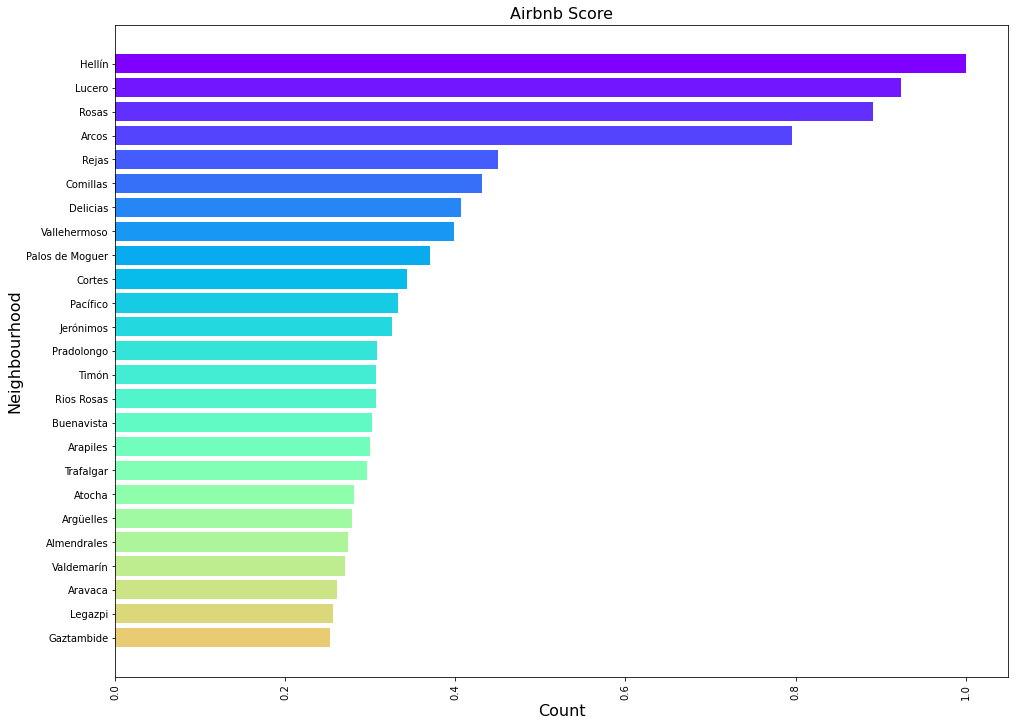

In [43]:
airbnb_cluster_score.sort_values(by=['airbnb_score'], ascending=False, inplace=True)
count = airbnb_cluster_score['airbnb_score']
neighbourhood = airbnb_cluster_score['neighbourhood']

colors_ = cm.rainbow(np.linspace(0, 1, len(count.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Neighbourhood", fontsize = 16)
plt.title("Airbnb Score", fontsize = 16)
plt.barh(neighbourhood[:25], count[:25].values, color = colors_)
plt.gca().invert_yaxis()

### **Standardizing and creating an Airbnb score for cluster 2**

In [44]:
airbnb_cluster_score_ = airbnb_cluster[airbnb_cluster["cluster_labels"] == '2']
min_max_scaler = MinMaxScaler()
airbnb_cluster_score_[["airbnb_count", "medium_price"]] = min_max_scaler.fit_transform(airbnb_cluster_score_[["airbnb_count" , "medium_price"]])
airbnb_cluster_score_["airbnb_score"] = (airbnb_cluster_score_["airbnb_count"] * (-0.5)) + airbnb_cluster_score_["medium_price"]
airbnb_cluster_score_.sort_values(by=['airbnb_score'], ascending=False, inplace=True)
airbnb_cluster_score_[["airbnb_score"]] = min_max_scaler.fit_transform(airbnb_cluster_score_[["airbnb_score"]])
airbnb_cluster_score_.head()

<ipython-input-44-9358c6be3a72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_cluster_score_[["airbnb_count", "medium_price"]] = min_max_scaler.fit_transform(airbnb_cluster_score_[["airbnb_count" , "medium_price"]])
c:\users\juanma\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-44-9358c6be3a72>:4: SettingWithCopyWarning: 
A value is trying 

,neighbourhood,cluster_labels,airbnb_count,medium_price,airbnb_score
92,Piovera,2,0.101695,1.000000,1.000000
111,San Pascual,2,0.135593,0.957995,0.940099
47,El Pardo,2,0.006780,0.869003,0.915119
5,Alameda de Osuna,2,0.166102,0.929164,0.895306
76,Niño Jesús,2,0.145763,0.868243,0.843739


### **Visualizing neighbourhoods with greater potential**

<ipython-input-45-2fa273da99ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_cluster_score_.sort_values(by=['airbnb_score'], ascending=False, inplace=True)


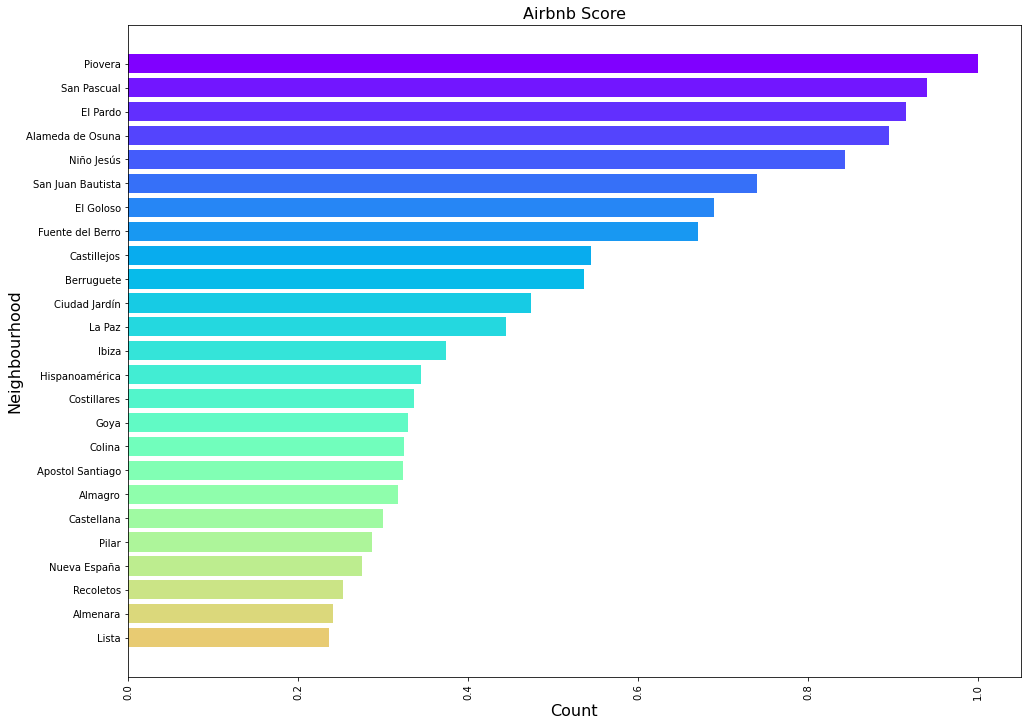

In [45]:
airbnb_cluster_score_.sort_values(by=['airbnb_score'], ascending=False, inplace=True)
count = airbnb_cluster_score_['airbnb_score']
neighbourhood = airbnb_cluster_score_['neighbourhood']

colors_ = cm.rainbow(np.linspace(0, 1, len(count.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Neighbourhood", fontsize = 16)
plt.title("Airbnb Score", fontsize = 16)
plt.barh(neighbourhood[:25], count[:25].values, color = colors_)
plt.gca().invert_yaxis()